# requirements

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from pathlib import Path
from glob import glob
import os
import pandas as pd
import numpy as np
import nltk
import spacy
from functional import seq
import string
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.linear_model import ARDRegression, HuberRegressor, SGDRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,r2_score
from sklearn.metrics import r2_score,\
    mean_squared_error, mean_absolute_percentage_error, mean_absolute_error,\
    median_absolute_error

from lightgbm import LGBMClassifier, LGBMRegressor, LGBMRanker

from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN, SMOTENC, RandomOverSampler

In [3]:
# !python -m spacy download uk_core_news_sm

In [ ]:
# git clone https://github.com/skupriienko/Ukrainian-Stopwords

In [4]:
stopwords = []
with open('./Ukrainian-Stopwords/stopwords_ua.txt') as f:
    for line in f.readlines():
        stopwords.append(line.strip())
STOPWORDS = set(stopwords)

In [5]:
# pip install pandarallel

In [6]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# EDA+processing

In [7]:
data = pd.read_csv('./data/data.csv',delimiter='\t\t\t')

In [8]:
data['smartphone_title'].nunique()

437

In [9]:
nlp = spacy.load("uk_core_news_sm")

In [10]:
doc = nlp(data['comment_text'].iloc[0].strip('\''))

In [11]:
def preprocess(text):
    doc = nlp(text)
    tokens = seq(doc)\
        .map(lambda token: token.lemma_.lower())\
        .filter(lambda token: token not in STOPWORDS)\
        .filter(lambda token_list: len(token_list)>=1)\
        .filter(lambda token: token not in string.punctuation)\
        .to_list()
    return tokens

In [12]:
data['comment_text_preprocessed'] = data['comment_text'].parallel_apply(preprocess)

In [13]:
data["comment_text_preprocessed_string"] = data["comment_text_preprocessed"]\
        .parallel_apply(lambda tokens: " ".join(tokens))

The data is unbalanced, as it is showed on the plot below

<Axes: ylabel='Frequency'>

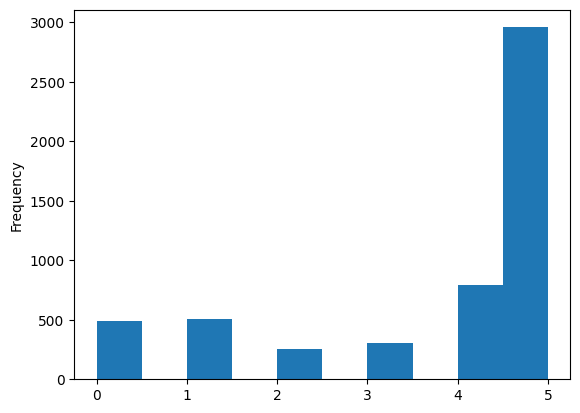

In [14]:
data['score'].plot(kind='hist')

In [15]:
data['comment_text_preprocessed_string']

0       гарний телефон круто виглядати розмір зручний ...
1       сегодня забрал телефон как оказалось телефон д...
2       добрий смартфон гарний обслуговування салон ро...
3        сучасний дорогий характеристика ціна нема рівний
4       целом телефон соответствует своей стоимости.\n...
                              ...                        
5303    тиждень користуватися дані смартфон функціонал...
5304    модель телефона новий очень классно работает м...
5305    замечательный телефон данную марка выбрал отзы...
5306                                попробую может зайдёт
5307                     дякувати швидко прийти працювати
Name: comment_text_preprocessed_string, Length: 5308, dtype: object

# Model

In [16]:
tf_idf_vectorizer = TfidfVectorizer(strip_accents='ascii')

In [17]:
X = data['comment_text_preprocessed_string']
y = data['score'].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=42)

In [18]:
tf_idf_vectorizer.fit(X_train)

TfidfVectorizer(strip_accents='ascii')

In [19]:
X_train = tf_idf_vectorizer.transform(X_train)
X_test = tf_idf_vectorizer.transform(X_test)

In [20]:
random_over_sampler = RandomOverSampler(random_state=42)
X_train, y_train = random_over_sampler.fit_resample(X_train,y_train)

In [21]:
def pipeline_for_classification_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test_proba = model.predict_proba(X_test)
    y_pred_test = model.predict(X_test)
    print('CLASSIFICATION REPORT: TRAIN')
    print(classification_report(y_train, y_pred_train))
    print('CLASSIFICATION REPORT: TEST')
    print(classification_report(y_test, y_pred_test))
    print('ROC-AUC: OVR')
    print(roc_auc_score(y_test, y_pred_test_proba, multi_class='ovr'))
    print('ROC-AUC: OVO')
    print(roc_auc_score(y_test, y_pred_test_proba, multi_class='ovo'))
    print('F1 weighted')
    print(f1_score(y_test,y_pred_test,average ='weighted'))
    sns.heatmap(confusion_matrix(y_train,np.round(y_pred_train)), annot=True, fmt = '.1f')

CLASSIFICATION REPORT: TRAIN
              precision    recall  f1-score   support

         0.0       0.79      0.24      0.36      2200
         1.0       0.70      0.26      0.38      2200
         2.0       0.73      0.33      0.46      2200
         3.0       0.75      0.30      0.43      2200
         4.0       0.73      0.25      0.38      2200
         5.0       0.21      0.85      0.33      2200

    accuracy                           0.37     13200
   macro avg       0.65      0.37      0.39     13200
weighted avg       0.65      0.37      0.39     13200

CLASSIFICATION REPORT: TEST
              precision    recall  f1-score   support

         0.0       0.11      0.05      0.07       119
         1.0       0.15      0.09      0.11       122
         2.0       0.08      0.07      0.08        69
         3.0       0.00      0.00      0.00        79
         4.0       0.22      0.11      0.15       179
         5.0       0.61      0.80      0.69       759

    accuracy        

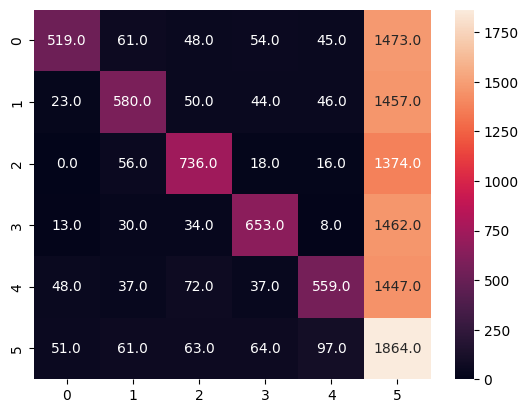

In [22]:
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
pipeline_for_classification_model(log_reg,X_train,X_test,y_train,y_test)

CLASSIFICATION REPORT: TRAIN
              precision    recall  f1-score   support

         0.0       0.20      0.88      0.33      2200
         1.0       0.67      0.24      0.35      2200
         2.0       0.66      0.31      0.42      2200
         3.0       0.67      0.28      0.39      2200
         4.0       0.74      0.21      0.33      2200
         5.0       0.65      0.12      0.20      2200

    accuracy                           0.34     13200
   macro avg       0.60      0.34      0.34     13200
weighted avg       0.60      0.34      0.34     13200

CLASSIFICATION REPORT: TEST
              precision    recall  f1-score   support

         0.0       0.08      0.66      0.14       119
         1.0       0.14      0.07      0.10       122
         2.0       0.09      0.09      0.09        69
         3.0       0.00      0.00      0.00        79
         4.0       0.24      0.09      0.13       179
         5.0       0.61      0.08      0.14       759

    accuracy        

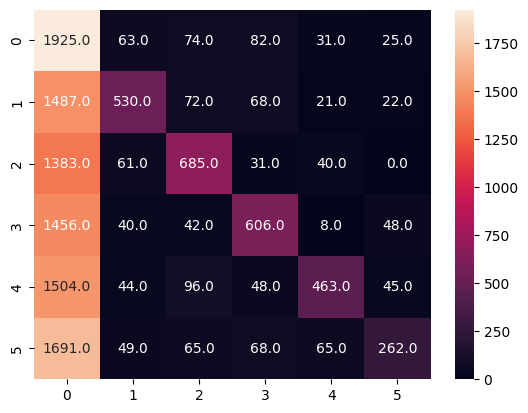

In [23]:
mutlinomial_nb = MultinomialNB()
pipeline_for_classification_model(mutlinomial_nb, X_train, X_test,y_train, y_test)

CLASSIFICATION REPORT: TRAIN
              precision    recall  f1-score   support

         0.0       0.78      0.22      0.35      2200
         1.0       0.85      0.24      0.37      2200
         2.0       0.76      0.33      0.46      2200
         3.0       0.86      0.28      0.42      2200
         4.0       0.84      0.23      0.37      2200
         5.0       0.21      0.91      0.34      2200

    accuracy                           0.37     13200
   macro avg       0.72      0.37      0.38     13200
weighted avg       0.72      0.37      0.38     13200

CLASSIFICATION REPORT: TEST
              precision    recall  f1-score   support

         0.0       0.08      0.03      0.05       119
         1.0       0.19      0.07      0.11       122
         2.0       0.13      0.10      0.11        69
         3.0       0.05      0.01      0.02        79
         4.0       0.21      0.09      0.13       179
         5.0       0.59      0.84      0.70       759

    accuracy        

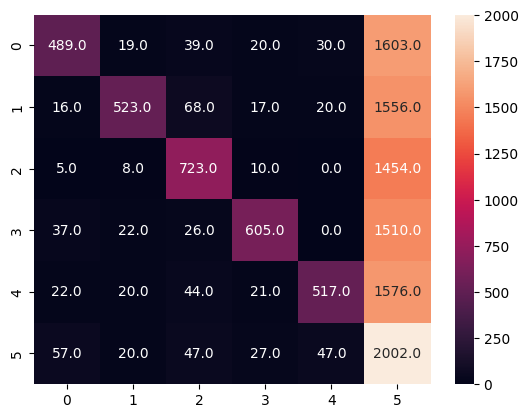

In [24]:
lgbm = LGBMClassifier(random_state=42)
pipeline_for_classification_model(lgbm,X_train,X_test,y_train,y_test)

In [25]:
def pipeline_for_regression_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = np.clip(y_pred_train,0,5)
    y_pred_test = np.clip(y_pred_test,0,5)
    print('REGRESSION REPORT: TRAIN')
    print('MSE')
    print(mean_squared_error(y_train, y_pred_train))
    print('MAE')
    print(mean_absolute_error(y_train, y_pred_train))
    print('MAPE')
    print(mean_absolute_percentage_error(y_train, y_pred_train))
    print('MedAE')
    print(median_absolute_error(y_train, y_pred_train))
    print('R2')
    print(r2_score(y_train, y_pred_train))
    print('F1 weighted')
    print(f1_score(y_train, np.round(y_pred_train), average = 'weighted'))
    
    
    print('REGRESSION REPORT: TEST')
    print('MSE')
    print(mean_squared_error(y_test, y_pred_test))
    print('MAE')
    print(mean_absolute_error(y_test, y_pred_test))
    print('MAPE')
    print(mean_absolute_percentage_error(y_test, y_pred_test))
    print('MedAE')
    print(median_absolute_error(y_test, y_pred_test))
    print('R2')
    print(r2_score(y_test, y_pred_test))
    print('F1 weighted')
    print(f1_score(y_test, np.round(y_pred_test), average = 'weighted'))
    
    

In [26]:
lgbm = LGBMRegressor(random_state=42)
pipeline_for_regression_model(lgbm,X_train,X_test,y_train,y_test)

REGRESSION REPORT: TRAIN
MSE
2.4963177729712984
MAE
1.3147527626932347
MAPE
1644130056709892.0
MedAE
1.458550038464498
R2
0.14411962069555484
F1 weighted
0.20243693322517442
REGRESSION REPORT: TEST
MSE
4.514228256021407
MAE
1.9820026786893605
MAPE
1021367181452186.9
MedAE
2.458550038464498
R2
-0.4797721655165257
F1 weighted
0.03818897874949979
